(tut_sgp4_propagator)=

# A differentiable SGP4 propagator

```{versionadded} 5.1.0

```

[SGP4](https://en.wikipedia.org/wiki/Simplified_perturbations_models) is an analytical orbital propagator widely used in the aerospace community to compute predictions of the positions and velocities of objects orbiting the Earth. It belongs to the class of so-called *general perturbation techniques*, and it owes its popularity in large part to its performance and to the fact that it supports [two-line elements (TLEs)](https://en.wikipedia.org/wiki/Two-line_element_set) data in their original format.

Starting with version 5.1.0, heyoka.py provides an original SGP4 implementation whose hallmark features are differentiability (up to arbitrary order) and high performance via multi-threaded parallelisation and [SIMD](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data) vectorisation. Differentiability is key in enabling a host of traditional astrodynamical applications, such as state covariance propagation, state transition matrix computation, gradient-based optimisation, orbit determination, etc. In recent years, differentiability has become important also in applications based on statistical and machine-learning methods - see for instance ESA's [differentiable SGP4 library](https://github.com/esa/dSGP4) (which is built on top of the standard machine-learning Python stack) and the [accompanying paper](https://arxiv.org/abs/2402.04830).

In this tutorial, we will walk through the API and showcase the main features of heyoka.py's SGP4 propagator.

```{note}

At this time, heyoka.py's SGP4 propagator does not implement support for deep-space propagation (i.e., the so-called SDP4 algorithm). As a consequence, the propagator will throw an exception if a deep-space orbit is detected.
Please [let us know](https://github.com/bluescarni/heyoka.py/issues) if you are interested in support for deep-space propagations.

```

## Getting the TLEs

The SGP4 algorithm takes in input a general perturbations element set (GPE), which contains the averaged orbital elements of the satellite at a reference epoch, the [drag coefficient](https://en.wikipedia.org/wiki/BSTAR) and additional information not used in the orbital propagation. Up-to-date GPEs in the form of two-line elements (TLEs) can be downloaded from several resources on the web, including [CelesTrak](https://celestrak.org/) and [Space-Track](https://www.space-track.org). For the purpose of this tutorial, we will be using an offline copy of the TLE catalog of all objects tracked by [Space-Track](https://www.space-track.org), downloaded in July 2024. In order to parse the TLE data, we will be using the [Skyfield](https://rhodesmill.org/skyfield) library.

Let us begin by loading the TLE data:

In [5]:
from skyfield.api import load
from skyfield.iokit import parse_tle_file

# Load the TLE data using the Skyfield library. See also:
#
# https://rhodesmill.org/skyfield/earth-satellites.html
satellites = list(parse_tle_file(load.open('satcat.3le'), load.timescale()))
print(f"Total number of objects: {len(satellites)}")

Total number of objects: 26389


Because, as mentioned earlier, heyoka.py's SGP4 propagator does not support deep-space objects, we have to remove them from the satellites list. We can accomplish this with the help of the {py:func}`~heyoka.model.gpe_is_deep_space()` function:

In [6]:
import heyoka as hy

# Retain only non-deep-space satellites
sats = list(filter(lambda sat: not hy.model.gpe_is_deep_space(sat.no_kozai, sat.ecco, sat.inclo),
                  (sat.model for sat in satellites)))

print(f"Total number of objects (excluding deep-space): {len(sats)}")

Total number of objects (excluding deep-space): 22333


We can see how we removed just around 4000 objects from a total of about 26000. Indeed, most tracked Earth-orbiting objects are in low-Earth orbit.

## Building an SGP4 propagator

We can now proceed to build an SGP4 propagator via the {py:func}`~heyoka.model.sgp4_propagator()` function:

In [7]:
prop = hy.model.sgp4_propagator(sats)

{py:func}`~heyoka.model.sgp4_propagator()` takes as only mandatory input argument the list of satellites, represented as ``Satrec`` objects from the [sgp4 Python module](https://pypi.org/project/sgp4/) (on which Skyfield depends). It returns a propagator object, by default of type {py:func}`~heyoka.model.sgp4_propagator_dbl()` (i.e., a double-precision propagator). You can also request a single-precision propagator via the {ref}`fp_type keyword argument <api_common_kwargs_fp_type>`.

## Understanding the data layout

Before moving on to use the propagator to actually compute some orbits, we need to discuss briefly the data layout expected and adopted by the propagator API.

In order to extract maximum performance via the use of [SIMD](https://en.wikipedia.org/wiki/Single_instruction,_multiple_data) instructions, the propagator API requires that data referring to different satellites is stored contiguously in a [structure of arrays](https://en.wikipedia.org/wiki/AoS_and_SoA) fashion.

As an example of what this means, we can take a look at the shape of the {py:attr}`~heyoka.model.sgp4_propagator_dbl.sat_data` property of the propagator class, which is a two-dimensional array containing the GPE data for all the satellites:

In [8]:
prop.sat_data.shape

(9, 22333)

We can see that we have 9 rows (each referring to a different GPE quantity) and 22333 columns (each referring to a different satellite). Thus, for instance, the GPE mean motions for all satellites are stored contiguously next to each other in the first row of the array:

In [9]:
# Print the GPE mean motions of all satellites.
prop.sat_data[0]

array([0.04736197, 0.05185823, 0.05002965, ..., 0.05346113, 0.05652762,
       0.07130705], shape=(22333,))

As mentioned earlier, this data layout allows to extract optimal performance via the use of SIMD instructions, but on the other hand it may be less user-friendly than a layout in which each row contains the data of a different satellite. Luckily, NumPy makes it very easy to reshape the data in any desired form. For instance, with a simple transposition we can achieve the one-satellite-per-row data layout:

In [6]:
# Transpose sat_data so that each rows
# contains all GPE data for a single
# satellite
prop.sat_data.T.shape

(22333, 9)

## Scalar propagation

We are now ready to perform our first orbit propagation by invoking the call operator of the propagator object, which accepts in input a list of propagation times (one per satellite). The times can be passed either as an array of floating-point values, or as an array of Julian dates (represented via the {py:attr}`~heyoka.model.sgp4_propagator_dbl.jdtype` datatype). In the former case, the times are interpreted as minutes elapsed since the GPE reference epoch of the satellite. In the latter case, the state of each satellite is propagated up to the specified Julian date. Here we will be focusing on date-based propagation as it is by far the most useful one.

We begin by creating an (empty) array of Julian dates:

In [10]:
import numpy as np
dates = np.zeros((prop.nsats,), dtype=prop.jdtype)

Julian dates are represented via the {py:attr}`~heyoka.model.sgp4_propagator_dbl.jdtype` type, which is a {ref}`structured NumPy datatype<numpy:defining-structured-types>` consisting of
two floating-point fields, the first one called ``jd`` and representing a Julian date, the second one called ``frac`` representing a fractional correction to ``jd`` (so that the full
Julian date is ``jd + frac``).

Although in principle we could propagate each satellite to a different date, here we will be propagating *all* satellites to the same Julian date:

In [11]:
# Pick a Julian date somewhere in July 2024.
dates["jd"] = 2460496.5

We also set some random value for the fractional part:

In [12]:
dates["frac"] = 0.5833449099999939

```{note}

Splitting the Julian date in two parts allows to increase the time resolution, which is limited to circa 1 microsecond for contemporary Julian dates when using a single double-precision value. If you are ok with such accuracy, you can just set the fractional part to zero.

```

We are now ready to propagate the state of the satellites:

In [13]:
# Compute the state vectors of all satellites
# at the specified Julian date.
sv = prop(dates)

The propagation returns a two-dimensional array, in which the first 6 rows contain the Cartesian state vector (position and velocity) of all satellites in the TEME reference frame, while the last row contains a status flag which, if nonzero, signals that an error was detected during the propagation:

In [14]:
sv.shape

(7, 22333)

Thus, for instance, if we want to extract the propagated state vector of the first satellite, we can write:

In [15]:
sv[:6, 0]

array([ 9.94002471e+03, -2.21458911e+03, -3.67188430e+02,  9.98417155e-01,
        4.56880512e+00,  3.18182714e+00])

The position (first 3 values) is returned in kilometers, while the velocity (last 3 values) is returned in kilometers per second. The status flags (contained in the 7th row of ``sv``) can assume the following integral values:

- 0: no error was detected,
- 1: the mean eccentricity is outside the range [0.0, 1.0],
- 2: the mean mean motion is less than zero,
- 3: the perturbed eccentricity is outside the range [0.0, 1.0],
- 4: the semilatus rectum is less than zero,
- 5: the satellite was underground (**NOTE**: this error code is no longer in use),
- 6: the satellite has decayed.

Let us now check the results of the propagation with those computed by the [sgp4 Python module](https://pypi.org/project/sgp4/), which wraps the [official C++ code](https://celestrak.org/software/vallado-sw.php) from CelesTrak:

In [16]:
# Propagate with the sgp4 module.
from sgp4.api import SatrecArray
sat_arr = SatrecArray(sats)
e, r, v = sat_arr.sgp4(np.array([2460496.5]), np.array([0.5833449099999939]))

Before doing the comparison, however, we have to account for the fact that the propagation may have errored out for some satellites. This can happen for instance if a satellite has decayed back to the Earth before the propagation date. Although the SGP4 algorithm does some error detection, it is not perfect, and thus, in addition to checking the error code ``e``, we also filter out satellites whose position is far outside LEO or contains non-finite values:

In [17]:
# Mask out the satellites that:
# - generated an error code, or
# - ended up farther than 8000km from the Earth, or
# - contain non-finite positional data.
mask = np.logical_and.reduce((
    e[:, 0] == 0,
    np.linalg.norm(r[:, 0], axis=1) < 8000,
    np.all(np.isfinite(r[:, 0]), axis=1)
))

We are now ready to plot the positional errors (in meters) for all satellites:

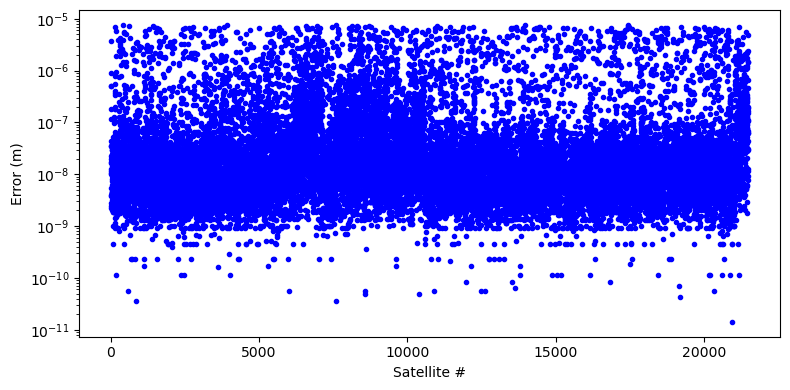

In [18]:
%matplotlib inline

import matplotlib.pylab as plt

fig = plt.figure(figsize=(8,4))

# Compute the positional error in meters.
err = np.linalg.norm(r[mask, 0] - sv[:3, mask].T, axis=1) * 1e3

# Plot it.
plt.semilogy(err, '.', color='blue')

plt.xlabel("Satellite #")
plt.ylabel("Error (m)")

plt.tight_layout();

We can see how the error of our implementation stays well below the millimeter level for all satellites.

## Batch propagation

In addition to being able to propagate the state of a satellite to a single date, our propagator is also capable of propagating the state to multiple dates at a time. We call this *batch mode* propagation.

Batch mode is enabled by simply passing a two-dimensional array of dates to the call operator of the propagator, rather than a one-dimensional list. As usual with batch mode in heyoka.py, the number of columns must be equal to the number of satellites, while the number of rows represents the number of propagations to be performed per satellite:

In [19]:
# Define a range of 30 days after our reference
# Julian date 2460496.5.
date_range = np.arange(2460496.5, 2460496.5 + 30)

# Create the array of dates for batch-mode propagation.
batch_dates = np.zeros((30, prop.nsats), dtype=prop.jdtype)

# Set the propagation dates to date_range for all satellites.
batch_dates['jd'] = np.repeat(date_range, prop.nsats).reshape((30, prop.nsats))
# Set all fractional parts to a random value.
batch_dates['frac'] = 0.5833449099999939

We can now compute the propagation in batch mode:

In [20]:
batch_sv = prop(batch_dates)

Let us take a look at the shape of the array of results:

In [21]:
batch_sv.shape

(30, 7, 22333)

The first dimension is the number of propagation dates we are using for each satellite (i.e., 30). Thus, for instance, if we are interested in fetching the states of all the satellites 10 days after the initial date, we can type:

In [22]:
batch_sv[10]

array([[-5.40251485e+03, -4.69145602e+03,  9.55769655e+03, ...,
         1.41678672e+03,  3.28778318e+03, -3.62718041e+03],
       [-2.89036662e+03,  5.36701569e+03,  5.09840792e+02, ...,
        -1.04676752e+03, -5.03552829e+02, -4.58439426e+03],
       [-3.87972378e+03, -4.59244765e+03, -8.68321583e+02, ...,
         7.67431517e+03, -6.92301072e+03, -7.78967974e+02],
       ...,
       [-6.74147963e+00, -4.84579238e+00,  4.94057779e+00, ...,
         6.72691919e+00, -1.05109071e+00,  1.86707617e+00],
       [-1.78968059e+00,  7.17637365e-01, -3.13760364e+00, ...,
         1.27142972e+00,  3.09883769e+00, -7.98112991e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],
      shape=(7, 22333))

The other two dimensions are, as in the scalar case, the number of propagated quantities and the number of satellites.

Let us now repeat the same computation with the sgp4 Python module, which also supports batch propagation:

In [23]:
batch_e, batch_r, batch_v = sat_arr.sgp4(date_range,
                                         np.array([0.5833449099999939]).repeat(30))

And let us plot the error of our implementation over the month-long propagation:

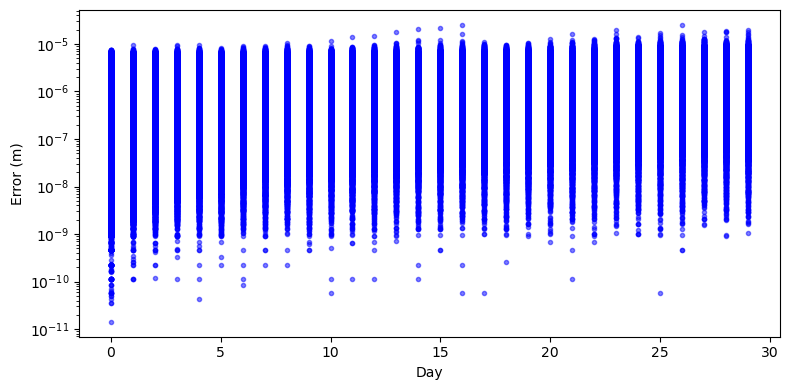

In [24]:
%matplotlib inline

import matplotlib.pylab as plt

fig = plt.figure(figsize=(8,4))

for i, ssv in enumerate(batch_sv):
    cur_mask = np.logical_and.reduce((
        batch_e[:, i] == 0,
        np.linalg.norm(batch_r[:, i], axis=1) < 8000,
        np.all(np.isfinite(batch_r[:, i]), axis=1),
    ))
    
    # Compute the positional error in meters
    # for the current date.
    err = np.linalg.norm(batch_r[cur_mask, i] - ssv[:3, cur_mask].T, axis=1) * 1e3

    # Plot it.
    plt.semilogy([date_range[i] - 2460496.5]*np.sum(cur_mask), err, '.',
                 alpha=.5, color='blue')

plt.xlabel("Day")
plt.ylabel("Error (m)")

plt.tight_layout();

We can see again how, throughout the month-long propagation, the error of our implementation remains well below the millimeter level.

## Computing derivatives

As we mentioned in the introduction, our SGP4 implementation is fully differentiable - meaning that it supports not only the propagation of state vectors, but also of their derivatives.

At this time, the derivatives with respect to the GPE orbital elements and the BSTAR coefficient are computed, but it is not difficult to add the ability to fully customise the list of quantities with respect to which the derivatives are computed. Please [let us know](https://github.com/bluescarni/heyoka.py/issues) if you are interested in such a feature.

In order to enable the computation of derivatives, we need to pass a nonzero ``diff_order`` to the {py:func}`~heyoka.model.sgp4_propagator()` function:

In [26]:
# Build a first-order differentiable propagator.
dprop = hy.model.sgp4_propagator(sats, diff_order=1, compact_mode=True)

Note how we enabled the ``compact_mode`` flag: the computation of the derivatives will generate very large symbolic expressions, and enabling compact mode allows us to keep the compilation times at a manageable level.

We can confirm that ``dprop`` is a differentiable propagator by taking a look at its {py:attr}`~heyoka.model.sgp4_propagator_dbl.diff_order` property:

In [27]:
dprop.diff_order

1

We can also query the list of quantities with respect to which the derivatives are computed via the {py:attr}`~heyoka.model.sgp4_propagator_dbl.diff_args` property:

In [28]:
dprop.diff_args

[n0, e0, i0, node0, omega0, m0, bstar]

These are the standard GPE quantities, specifically:

- ``n0``: the mean motion,
- ``e0``: the eccentricity,
- ``i0``: the inclination,
- ``node0``: the right ascension of the ascending node,
- ``omega0``: the argument of perigee,
- ``m0``: the mean anomaly,
- ``bstar``: the BSTAR coefficient.

We can use the differentiable propagator exactly in the same way as the non-differentiable one:

In [29]:
# Compute the state vectors and derivatives of all satellites
# at the specified Julian date.
dsv = dprop(dates)

Note however that the propagation output now contains more quantities per satellite:

In [26]:
dsv.shape

(56, 22333)

In addition to the 7 propagation outputs, now we also have the $7 \times 7 = 49$ derivatives of the outputs with respect to the GPE quantities, for a total of 56 output quantities. The derivatives are stored in the propagation output right after the state, in row-major order. For instance, the index range $\left[ 7, 14 \right)$ contains the derivatives of the Cartesian position $x$ with respect to the GPE quantities (in the order they show up in {py:attr}`~heyoka.model.sgp4_propagator_dbl.diff_args`). The index range $\left[ 14, 21 \right)$ contains the derivatives of the Cartesian position $y$, and so on.

This means that we can easily fetch the Jacobian of, say, the first satellite's state vector as:

In [27]:
dsv[7:, 0].reshape((7, 7))

array([[ 2.52231381e+04,  7.96701510e+03,  4.32972861e+01,
         2.21458911e+03,  2.03043357e+03,  1.26423088e+03,
        -9.15870370e-01],
       [ 7.86813221e+05, -3.44192784e+03,  2.69901893e+02,
         9.94002471e+03,  8.18427858e+03,  5.78621933e+03,
         2.78149747e+00],
       [ 5.32584971e+05, -1.38714529e+03, -6.26383574e+02,
         0.00000000e+00,  5.72154816e+03,  4.02580545e+03,
         1.76872564e+00],
       [-6.13130760e+02, -5.77824309e-01, -4.61811875e-01,
        -4.56880512e+00, -5.54333858e+00, -4.74511204e+00,
        -1.84381283e-03],
       [ 1.70347065e+02, -4.78977349e+00, -3.15531992e+00,
         9.98417155e-01,  1.12429140e+00,  1.05724585e+00,
         9.64395926e-04],
       [ 4.54229209e+01, -3.28117498e+00,  4.66732813e+00,
         0.00000000e+00,  1.30646137e-01,  1.75512032e-01,
         4.40393021e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0000000

Note how the derivatives of the error codes (last row) are all zeros, as the error codes are discrete quantities.

When moving to higher differentiation orders, fetching specific derivatives can quickly become complicated. The propagator class provides a couple of helpers to ease the task of locating derivatives in the propagation output. The basic logic is the same explained in the tutorials about [computing derivatives](<./computing_derivatives.ipynb>) and [the variational equations](<./var_ode_sys.ipynb>), so it should be fairly familiar to heyoka.py users.

The first helper is the {py:func}`~heyoka.model.sgp4_propagator_dbl.get_dslice()` method. This method takes as input a differentiation order and, optionally, a component index, and returns a {class}`slice` into the output corresponding to the range of requested derivatives. Let us see a couple of examples:

In [28]:
# Fetch the range of all order-1 derivatives.
dprop.get_dslice(order=1)

slice(7, 56, None)

In [29]:
# Fetch the range of order-1 derivatives
# of the Cartesian position z (component=2).
dprop.get_dslice(order=1, component=2)

slice(21, 28, None)

We can directly use the slices returned by {py:func}`~heyoka.model.sgp4_propagator_dbl.get_dslice()` for indexing into the propagator output:

In [30]:
# Print the first-order derivatives of the z
# coordinate of the first satellite.
dsv[dprop.get_dslice(order=1, component=2), 0]

array([ 5.32584971e+05, -1.38714529e+03, -6.26383574e+02,  0.00000000e+00,
        5.72154816e+03,  4.02580545e+03,  1.76872564e+00])

The second helper is the {py:func}`~heyoka.model.sgp4_propagator_dbl.get_mindex()` method. Given an integral index into the output of a differentiable propagator, this method returns the differentiation multiindex associated to that output quantity.
The multiindex returned by {py:func}`~heyoka.model.sgp4_propagator_dbl.get_mindex()` begins with the component index, while the remaining indices represent the differentiation orders. Let us see a couple of examples.

We know from earlier that at index 7 we have the first-order derivative of component 0 (i.e., the Cartesian $x$ position of the satellite) with respect to the first GPE orbital element - that is, $\frac{\partial x}{\partial n_0}$. Let us check:

In [30]:
dprop.get_mindex(i=7)

[0, 1, 0, 0, 0, 0, 0, 0]

We can see that the component index (the first integer) is indeed 0, and that the only nonzero differentiation index is the one corresponding to ``n0`` (i.e., the second integer). Moving to index 8, we expect to see the multiindex corresponding to $\frac{\partial x}{\partial e_0}$. Let us check:

In [31]:
dprop.get_mindex(i=8)

[0, 0, 1, 0, 0, 0, 0, 0]

Indeed, everything checks out.

## Performance evaluation

In this section, we will run a benchmark to test the batch-mode performance of our propagator.

For the purpose of this test, we will be propagating the state vectors of all satellites at 10000 different dates, so that we will be dealing with a total of roughly 223 million propagations.

In [33]:
# Create a grid of 10'000 Julian dates over 30 days.
date_range = np.linspace(2460496.5, 2460496.5 + 30, 10000)

# Splat it out in the batch-mode data layout.
batch_dates = np.zeros((10000, prop.nsats), dtype=prop.jdtype)
batch_dates['jd'] = np.repeat(date_range, prop.nsats).reshape((10000, prop.nsats))
# Select a random fractional component for all dates.
batch_dates['frac'] = 0.5833449099999939

We also pre-allocate an array that will be used as output in the propagation. Pre-allocating the output array can improve performance, especially for repeated propagations:

In [34]:
# Prepare the output array.
out = np.zeros((10000, 7, prop.nsats))

Let us now time the execution on a 16-core AMD Ryzen 9 5950X:

In [35]:
%timeit prop(batch_dates, out=out)

1.32 s ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that our propagator is able to perform roughly 170M propagations per second on this 16-core machine.

We can evaluate the single-core performance by forcibly setting the number of threads in use by heyoka to 1:

In [36]:
hy.set_nthreads(1)

%time prop(batch_dates, out=out);

CPU times: user 17.6 s, sys: 105 μs, total: 17.6 s
Wall time: 17.6 s


On a single core, our propagator is capable of delivering roughly 13M propagations per second.

Let us see how the propagator from the sgp4 Python module performs:

In [37]:
%time sat_arr.sgp4(date_range, np.array([0.5833449099999939]).repeat(len(date_range)));

CPU times: user 1min 20s, sys: 832 ms, total: 1min 21s
Wall time: 1min 20s


We can see that in this single-threaded test our implementation is about 4 times faster than the one from the sgp4 Python module.